In [95]:
import sys, os
DMOL_DIR = "/Users/Henryye/research/shaf/DMOL"
sys.path.append(os.path.join(DMOL_DIR, "utils"))

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/CalebPitts/Documents/Files/School/College/19-20-Year/Research/DMOL/utils')
from ml_utils import *
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.decomposition import PCA, KernelPCA
from astropy.stats import median_absolute_deviation


import warnings
warnings.filterwarnings('ignore')

In [52]:
df_proc = pd.read_csv("/Users/CalebPitts/Documents/Files/School/College/19-20-Year/Research/data/proc_df.csv")
var_map = pickle.load(open("/Users/CalebPitts/Documents/Files/School/College/19-20-Year/Research/data/var_map.pkl", 'rb'))

In [53]:
def remove_outliers(df):
    '''
    remove outliers using MAD.
    '''
    for i, c in enumerate(list(df.columns)):
        mad, mu = median_absolute_deviation(df[c]), df[c].mean()
        for idx in df.index:
            if df.loc[idx, c] > mu + 3 * mad:
                df.loc[idx, c] = mu + 3 * mad
            elif df.loc[idx, c] < mu - 3 * mad:
                df.loc[idx, c] = mu - 3 * mad
    return df

In [54]:
def produce_nonlinear_pca(scree_data, df, var_map_curr, kernel, week_num, n_comp=5):
    X = pd.DataFrame()
    target = ""
    
    pca = KernelPCA(n_components=n_comp, kernel=kernel, degree=3)
    for construct in var_map_curr["Quant"]:
        temp = df[list(var_map_curr["Quant"][construct])].copy()
        temp = temp.fillna(temp.median())  # use median to fillna
        temp = remove_outliers(temp) 
        temp = temp.fillna(temp.mode().iloc[0])
        #if len(var_map_curr["Quant"][construct]) < n_comp:
        #    X = pd.concat([X, temp.copy()], axis = 1)
        if True:
            temp_pca = pd.DataFrame(pca.fit_transform(temp))
            temp_pca.columns = ["{}_PC{}".format(construct, i) for i in range(1, n_comp+1)]
            X = pd.concat([X, temp_pca], axis = 1)
            
            explained_variance = np.var(temp_pca, axis=0)
            explained_variance_ratio = explained_variance / np.sum(explained_variance)
            scree_row = {"Target Week": week_num, "Construct": construct, "Kernel": kernel}
            for i, comp_var in enumerate(explained_variance_ratio):
                scree_row["Component " + str(i+1)] = round(comp_var, 5)
            
            scree_data.append(scree_row)
    
    return X, scree_data

In [55]:
def standardize_X(X):
    X_vals = X.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_vals_scaled = min_max_scaler.fit_transform(X_vals)
    X = pd.DataFrame(x_vals_scaled)
    
    return X

In [65]:
def classify_response(X, y):
    halves = []
    for val in y:
        if val in [1,2]:
            halves.append(1)
        else:
            halves.append(2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, halves, test_size = 0.3, random_state = 42)
    
    accs = []
    for n in range(3, 15):
        #print("\nN Estimators:", n)
        mod = RandomForestClassifier(n_estimators=n, max_depth=None).fit(X_train, y_train)
    
        y_train_pred = mod.predict(X_train)
        #print("Training Accuracy: {}".format(accuracy_score(y_train, y_train_pred)))

        y_test_pred = mod.predict(X_test)
        #print("Testing  Accuracy: {}".format(accuracy_score(y_test, y_test_pred)))
        accs.append((accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
        
    return accs

In [69]:
def optimal_classify_response(X, Y, n_estimators, max_depth):
    halves = []
    for val in y:
        if val in [1,2]:
            halves.append(1)
        else:
            halves.append(2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, halves, test_size = 0.3, random_state = 42)
    
    #print("\nN Estimators:", n)
    mod = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth).fit(X_train, y_train)
    
    y_train_pred = mod.predict(X_train)
    #print("Training Accuracy: {}".format(accuracy_score(y_train, y_train_pred)))

    y_test_pred = mod.predict(X_test)
    #print("Testing  Accuracy: {}".format(accuracy_score(y_test, y_test_pred)))
    return (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))

In [57]:
def get_scree_threshold(scree_data):
    scree_df = pd.DataFrame(scree_data)
    thresholds_broken = []
    for i in range(len(scree_df)):
        var_tot = 0
        passed = False
        for index in scree_df.iloc[i].index:
            if index.startswith("Component "):
                var_tot += scree_df.iloc[i][index]
                if var_tot > .90 and not passed:
                    passed = True
                    thresholds_broken.append(int(index.split()[1]))
        if not passed:
            thresholds_broken.append(-1)
    
    scree_df["Cum_90_Components"] = thresholds_broken
    
    return scree_df

In [58]:
def group_accs(all_accs):
    grouped_training_accs = []
    grouped_testing_accs = []
    for n in range(0, 12):  #iterate over n estimators
        training_accs_group = []
        testing_accs_group = []
        for accs in all_accs:
            training_accs_group.append(accs[n][0])
            testing_accs_group.append(accs[n][1])
        grouped_training_accs.append(sum(training_accs_group)/len(training_accs_group))
        grouped_testing_accs.append(sum(testing_accs_group)/len(testing_accs_group))
        
    return grouped_training_accs, grouped_testing_accs

In [59]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

In [60]:
def plot_scree_bars(scree_df, kernel):
    plt.bar(scree_df["Cum_90_Components"].value_counts().index, scree_df["Cum_90_Components"].value_counts().values)
    plt.title("# PC needed to achieve >90% Variance Captured Construct: {}".format(kernel))
    plt.xlabel("Number of Princinple Components")
    plt.ylabel("Number of Constructs")
    plt.show()

In [61]:
def plot_rf_n_estimators(grouped_training_accs, grouped_testing_accs, kernel):
    plt.plot(grouped_training_accs, label="training", marker='o', color='r')
    plt.plot(grouped_testing_accs, label="testing", marker='o', color='b')
    plt.title("All-Weeks Average Accuracy By # of Estimators: {}".format(kernel))
    plt.xlabel("N Estimators")
    plt.ylabel("Classification Accuracy")
    plt.legend()
    plt.show()

In [76]:
def print_optimal_accs(optimal_accs):
    for week, accs in optimal_accs.items():
        print("\nWeek {}:".format(week))
        print("Training Accuracy = {}".format(accs[0]))
        print("Testing Accuracy = {}".format(accs[1]))

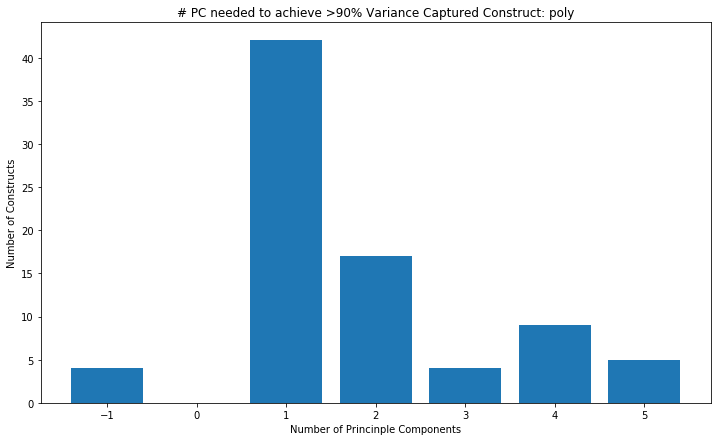

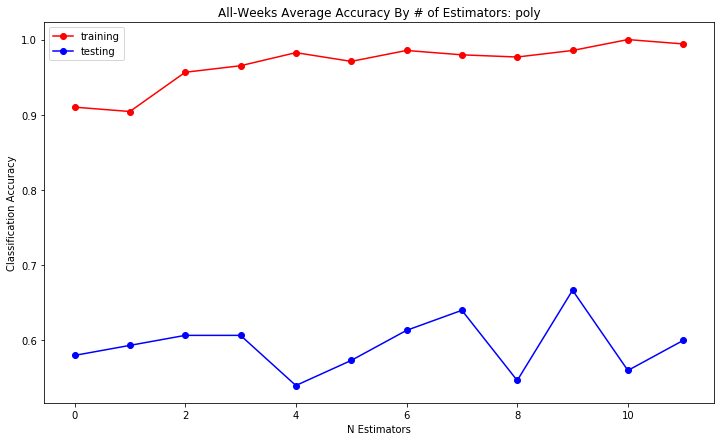


Week 1:
Training Accuracy = 0.9565217391304348
Testing Accuracy = 0.5666666666666667

Week 2:
Training Accuracy = 0.855072463768116
Testing Accuracy = 0.7666666666666667

Week 3:
Training Accuracy = 0.927536231884058
Testing Accuracy = 0.5333333333333333

Week 4:
Training Accuracy = 0.8840579710144928
Testing Accuracy = 0.5

Week 5:
Training Accuracy = 0.927536231884058
Testing Accuracy = 0.5666666666666667


In [110]:
scree_data = []
all_accs = []
optimal_accs = {}
for week_num in range(1, 6):
    #print("\n\nWeek {}:".format(week_num))
    var_map_curr = NEW_VAR_MAP["week_{}".format(week_num)]
    X, scree_data = produce_nonlinear_pca(scree_data, df_proc, var_map_curr, 'poly', week_num)
    scree_df = get_scree_threshold(scree_data)
        
    X = standardize_X(X)
    y = df_proc["gr_revq{}_quantile".format(week_num)]
    
    all_accs.append(classify_response(X, y))
    optimal_accs[week_num] = optimal_classify_response(X, y, 3, 8)
    
grouped_training_accs, grouped_testing_accs = group_accs(all_accs)
plot_scree_bars(scree_df, 'poly')
plot_rf_n_estimators(grouped_training_accs, grouped_testing_accs, 'poly')
print_optimal_accs(optimal_accs)

In [112]:
optimal_accs = defaultdict(list)
for week_num in range(1, 6):
    for depth in range(1,15):
        optimal_accs[week_num].append(optimal_classify_response(X, y, 3, depth))
        #print_optimal_accs(optimal_accs)

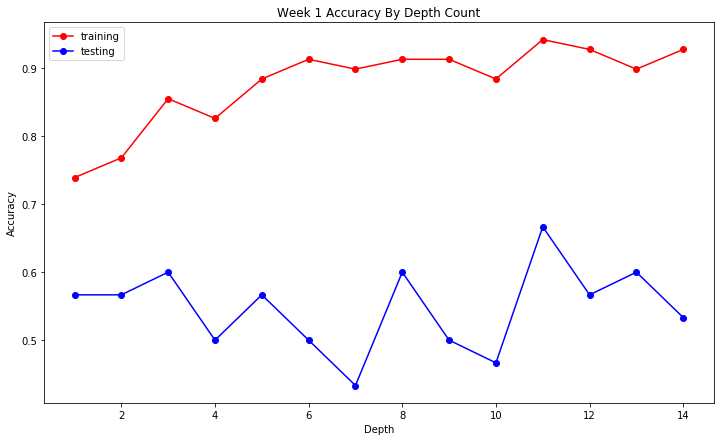

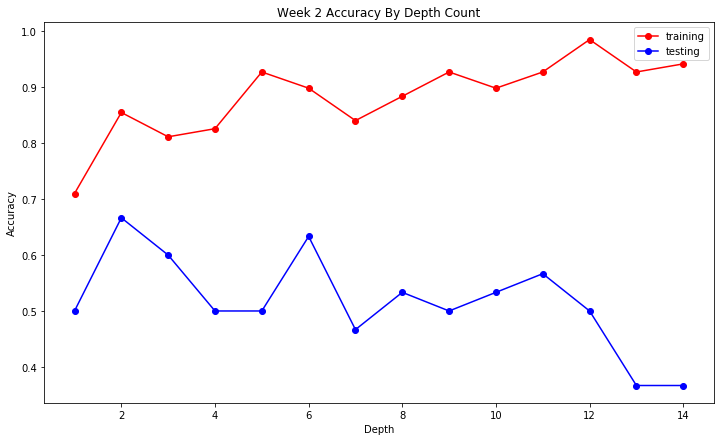

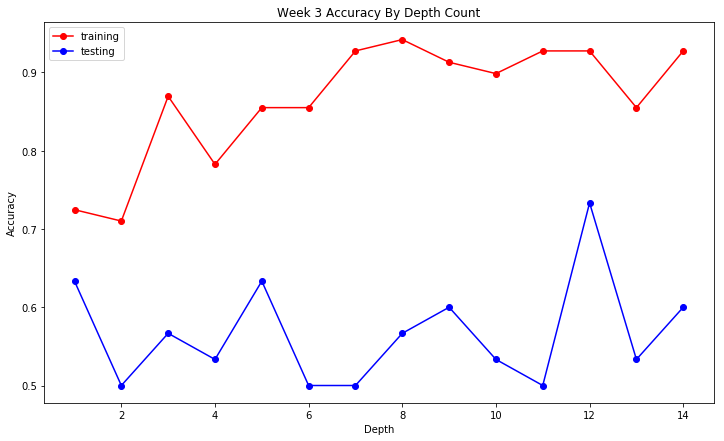

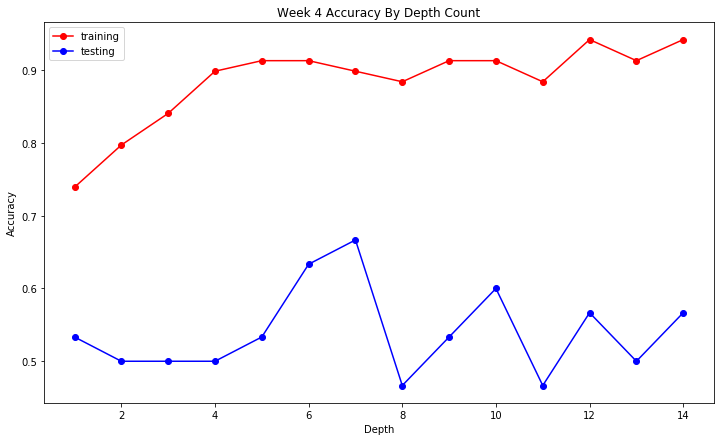

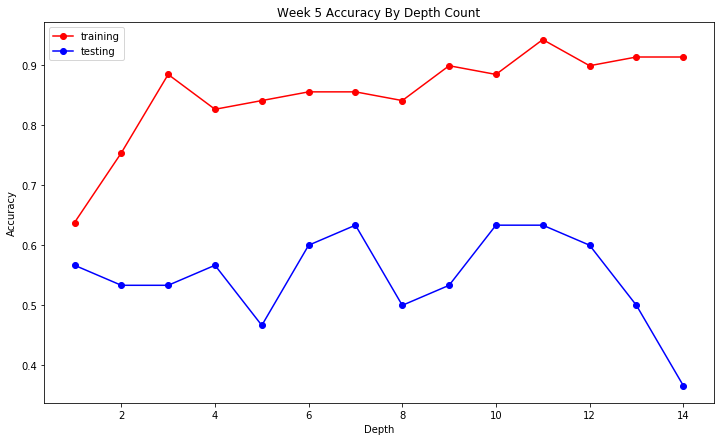

In [113]:
for week in optimal_accs.keys():
    trainings = []
    testings = []
    depths = []
    for depth, (training, testing) in enumerate(optimal_accs[week]):
        trainings.append(training)
        testings.append(testing)
        depths.append(depth+1)
        
    plt.plot(depths, trainings, label="training", marker='o', color='r')
    plt.plot(depths, testings, label="testing", marker='o', color='b')
    plt.title("Week {} Accuracy By Depth Count".format(week))
    plt.xlabel("Depth")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()